In [3]:
%matplotlib inline
import math,sys,os,numpy as np
from numpy.linalg import norm
from PIL import Image
from matplotlib import pyplot as plt, rcParams, rc
from scipy.ndimage import imread
from skimage.measure import block_reduce
#import cPickle as pickle
import pickle
from scipy.ndimage.filters import correlate, convolve
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *
rc('animation', html='html5')
rcParams['figure.figsize'] = 3, 6

%precision 4
np.set_printoptions(precision=4, linewidth=100)

In [4]:
"""
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/")
images, labels = mnist.train.images, mnist.train.labels
images = images.reshape((55000,28,28))
np.savez_compressed("MNIST_data/train", images=images, labels=labels)
"""
1

1

In [5]:
def plots(ims, interp=False, titles=None):
    ims=np.array(ims)
    mn,mx=ims.min(),ims.max()
    f = plt.figure(figsize=(12,24))
    for i in range(len(ims)):
        sp=f.add_subplot(1, len(ims), i+1)
        if not titles is None: sp.set_title(titles[i], fontsize=18)
        plt.imshow(ims[i], interpolation=None if interp else 'none', vmin=mn,vmax=mx)

def plot(im, interp=False):
    f = plt.figure(figsize=(3,6), frameon=True)
    plt.imshow(im, interpolation=None if interp else 'none')

plt.gray()
plt.close()

In [6]:
data = np.load("MNIST_data/train.npz")
images=data['images']
labels=data['labels']
n=len(images)
images.shape

(55000, 28, 28)

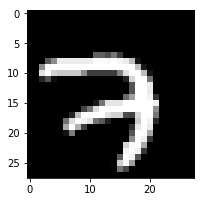

In [7]:
plot(images[0])

In [8]:
labels[0]

7

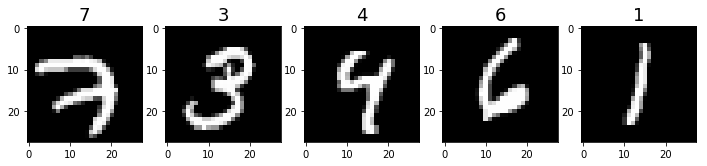

In [9]:
plots(images[:5], titles=labels[:5])

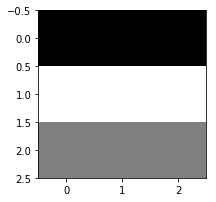

In [10]:
top=[[-1,-1,-1],
     [ 1, 1, 1],
     [ 0, 0, 0]]

plot(top)

In [11]:
r=(0,28)
def zoomim(x1=0,x2=28,y1=0,y2=28):
    plot(images[0,y1:y2,x1:x2])
w=interactive(zoomim, x1=r,x2=r,y1=r,y2=r)
w

A Jupyter Widget

In [47]:
k=w.kwargs
dims = np.index_exp[k['y1']:k['y2']:1,k['x1']:k['x2']]
print(images[0][dims])

[[ 0.      0.      0.    ]
 [ 0.      0.      0.    ]
 [ 0.8941  0.8941  0.8941]]


In [48]:
corrtop = correlate(images[0], top)

In [49]:
corrtop[dims]

array([[ 0.    ,  0.    ,  0.    ],
       [ 0.    ,  0.    ,  0.4157],
       [ 2.2471,  2.6824,  2.3647]], dtype=float32)

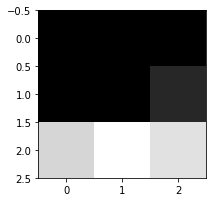

In [52]:
plot(corrtop[dims])

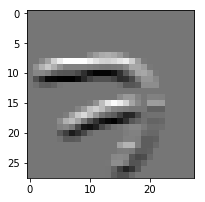

In [51]:
plot(corrtop)

In [32]:
np.rot90(top, 1)

array([[-1,  1,  0],
       [-1,  1,  0],
       [-1,  1,  0]])

True

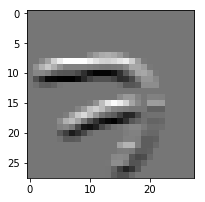

In [53]:
convtop = convolve(images[0], np.rot90(top,2))
plot(convtop)
np.allclose(convtop, corrtop)

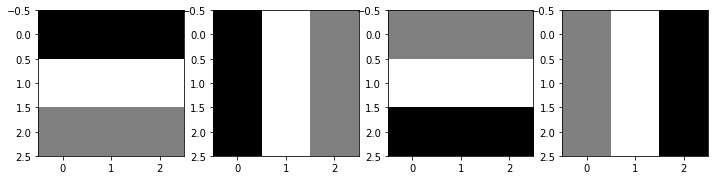

In [54]:
straights=[np.rot90(top,i) for i in range(4)]
plots(straights)

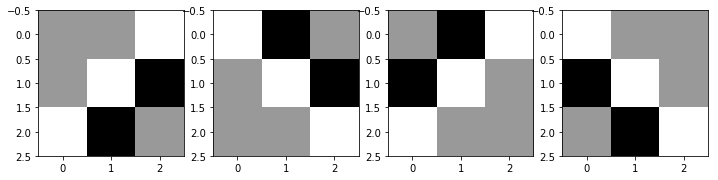

In [55]:
br=[[ 0, 0, 1],
    [ 0, 1,-1.5],
    [ 1,-1.5, 0]]

diags = [np.rot90(br,i) for i in range(4)]
plots(diags)

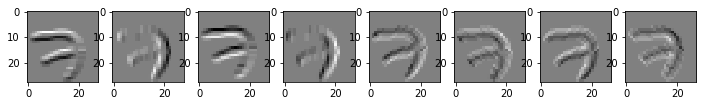

In [56]:
rots = straights + diags
corrs = [correlate(images[0], rot) for rot in rots]
plots(corrs)

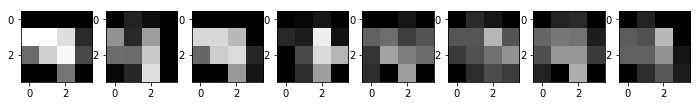

In [57]:
def pool(im): return block_reduce(im, (7,7), np.max)

plots([pool(im) for im in corrs])

In [59]:
eights=[images[i] for i in range(n) if labels[i]==8]
ones=[images[i] for i in range(n) if labels[i]==1]

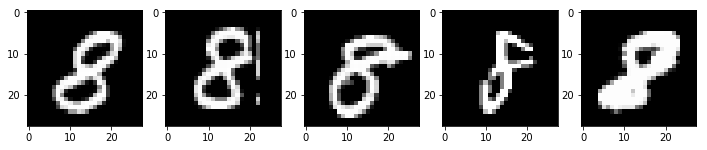

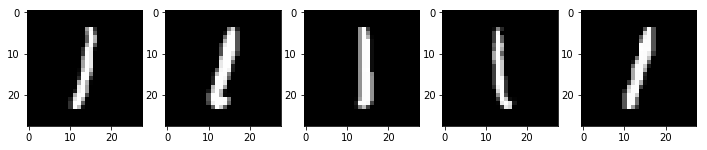

In [63]:
plots(eights[:5])
plots(ones[:5])

In [67]:
pool8 = [np.array([pool(correlate(im, rot)) for im in eights]) for rot in rots]

In [68]:
len(pool8), pool8[0].shape

(8, (5389, 4, 4))

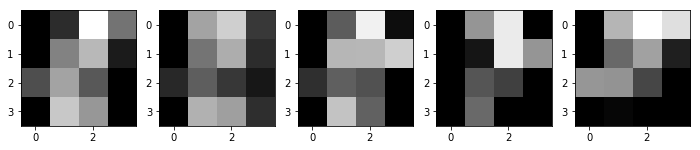

In [69]:
plots(pool8[0][0:5])

In [70]:
def normalize(arr): return (arr-arr.mean())/arr.std()

In [71]:
filts8 = np.array([ims.mean(axis=0) for ims in pool8])
filts8 = normalize(filts8)                                 

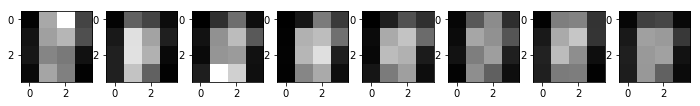

In [72]:
plots(filts8)

In [73]:
pool1 = [np.array([pool(correlate(im, rot)) for im in ones]) for rot in rots]
filts1 = np.array([ims.mean(axis=0) for ims in pool1])
filts1 = normalize(filts1)

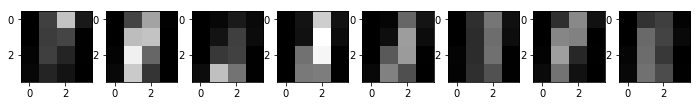

In [74]:
plots(filts1)

In [75]:
def pool_corr(im): return np.array([pool(correlate(im, rot)) for rot in rots])

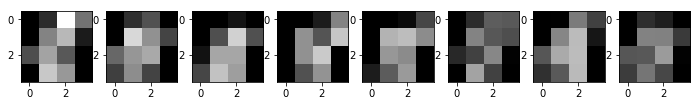

In [76]:
plots(pool_corr(eights[0]))

In [77]:
def sse(a,b): return ((a-b)**2).sum()
def is8_n2(im): return 1 if sse(pool_corr(im),filts1) > sse(pool_corr(im),filts8) else 0

In [78]:
sse(pool_corr(eights[0]), filts8), sse(pool_corr(eights[0]), filts1)

(126.77776, 181.26105)

In [79]:
[np.array([is8_n2(im) for im in ims]).sum() for ims in [eights,ones]]

[5223, 287]

In [38]:
[np.array([(1-is8_n2(im)) for im in ims]).sum() for ims in [eights,ones]]

[166, 5892]

In [80]:
def n1(a,b): return (np.fabs(a-b)).sum()
def is8_n1(im): return 1 if n1(pool_corr(im),filts1) > n1(pool_corr(im),filts8) else 0

In [81]:
[np.array([is8_n1(im) for im in ims]).sum() for ims in [eights,ones]]

[5129, 254]

In [82]:
[np.array([(1-is8_n1(im)) for im in ims]).sum() for ims in [eights,ones]]

[260, 5925]